In [35]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import mediapipe as mp
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

In [36]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [37]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, phase, grayscale_transform=None, color_transform=None):
        self.grayscale_dir = os.path.join(root_dir, phase, 'grayscale')
        self.color_dir = os.path.join(root_dir, phase, 'color')
        self.grayscale_transform = grayscale_transform
        self.color_transform = color_transform
        self.image_names = [f for f in os.listdir(self.grayscale_dir) if os.path.isfile(os.path.join(self.grayscale_dir, f))]
        
        self.labels = []
        self.valid_image_names = []
        for filename in self.image_names:
            if filename.startswith('grayscale_') or filename.startswith('color_'):
                parts = filename.split('_')
                try:
                    label = int(parts[1])
                    self.labels.append(label)
                    self.valid_image_names.append(filename)
                except ValueError:
                    continue
        
        self.image_names = self.valid_image_names

        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_path = os.path.join(self.grayscale_dir, self.image_names[idx])
        color_path = os.path.join(self.color_dir, self.image_names[idx])

        grayscale_image = Image.open(grayscale_path).convert('L')
        color_image = Image.open(color_path).convert('RGB')

        if self.grayscale_transform:
            grayscale_image = self.grayscale_transform(grayscale_image)
        if self.color_transform:
            color_image = self.color_transform(color_image)

        label = self.labels[idx]
        return grayscale_image, color_image, label

grayscale_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

color_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [38]:
root_dir = 'dataset5_dual_data'
train_dataset = PairedImageDataset(root_dir, 'train', grayscale_transform, color_transform)
val_dataset = PairedImageDataset(root_dir, 'val', grayscale_transform, color_transform)
test_dataset = PairedImageDataset(root_dir, 'test', grayscale_transform, color_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
class DualInputCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(DualInputCNN, self).__init__()

        # Grayscale CNN
        self.grayscale_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )

        # Landmark CNN
        self.landmark_cnn = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(50, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout2d(0.2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(32*3*3 + 25*10*1, 512)
        self.fc_dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)  # Assuming 10 classes

    def forward(self, grayscale, landmarks):
        # Grayscale pathway
        x1 = self.grayscale_cnn(grayscale)
        x1 = x1.view(-1, 32*3*3)

        # Color pathway
        x2 = self.landmark_cnn(landmarks)
        x2 = x2.view(-1, 25*10*1)

        # Concatenate and classify
        x = torch.cat((x1, x2), dim=1)
        x = self.fc_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [40]:
def process_with_mediapipe(color_images):
    batch_landmarks = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).cpu().numpy() 
        color_image_np = (color_image_np * 255).astype(np.uint8) 
        color_image_np = np.ascontiguousarray(color_image_np) 
        results = mp_hands.process(color_image_np)
        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
        # If no landmarks found or fewer than 21, fill with zeros
        while len(landmarks) < 21:
            landmarks.append([0.0, 0.0, 0.0])
        batch_landmarks.append(landmarks)
    landmarks_tensor = torch.tensor(batch_landmarks, dtype=torch.float32)
    return landmarks_tensor.view(len(color_images), 1, 21, 3).to(device) 


In [41]:
def get_num_classes(dataset):
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [42]:
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence = 0.25)
model = DualInputCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Training')

    for data in train_progress_bar:
        grayscale_images, color_images, labels = data

        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        landmarks = process_with_mediapipe(color_images)

        optimizer.zero_grad()
        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        train_progress_bar.set_postfix({
            'loss': running_loss / (train_progress_bar.n + 1),
            'accuracy': correct_predictions / total_predictions
        })
    epoch_train_loss = running_loss/len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracy = 100*correct_predictions/total_predictions
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    all_labels = []
    all_predictions = []
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Validation')

    with torch.no_grad():
        for data in val_progress_bar:
            grayscale_images, color_images, labels = data

            grayscale_images = grayscale_images.to(device)
            color_images = color_images.to(device)
            labels = labels.to(device)

            landmarks = process_with_mediapipe(color_images)

            outputs = model(grayscale_images, landmarks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            val_progress_bar.set_postfix({
                'val_loss': val_loss / (val_progress_bar.n + 1),
                'val_accuracy': val_correct_predictions / val_total_predictions
            })
    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}, Training accuracy: {correct_predictions / total_predictions:.3f}, Validation loss: {val_loss / len(val_loader):.3f}, Validation accuracy: {val_correct_predictions / val_total_predictions:.3f}')

print('Finished Training')



I0000 00:00:1717540260.794525 1058391 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2
W0000 00:00:1717540260.813364 1082719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717540260.819395 1082719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Epoch 1/10 Validation: 100%|██████████| 309/309 [06:56<00:00,  1.35s/it, val_loss=0.652, val_accuracy=0.792]


Epoch 1, Training loss: 1.433, Training accuracy: 0.543, Validation loss: 0.652, Validation accuracy: 0.792


Epoch 2/10 Validation: 100%|██████████| 309/309 [05:28<00:00,  1.06s/it, val_loss=0.371, val_accuracy=0.88] 


Epoch 2, Training loss: 0.700, Training accuracy: 0.767, Validation loss: 0.371, Validation accuracy: 0.880


Epoch 3/10 Validation: 100%|██████████| 309/309 [05:29<00:00,  1.07s/it, val_loss=0.241, val_accuracy=0.92] 


Epoch 3, Training loss: 0.491, Training accuracy: 0.836, Validation loss: 0.241, Validation accuracy: 0.920


Epoch 4/10 Validation: 100%|██████████| 309/309 [05:24<00:00,  1.05s/it, val_loss=0.204, val_accuracy=0.931]


Epoch 4, Training loss: 0.387, Training accuracy: 0.869, Validation loss: 0.204, Validation accuracy: 0.931


Epoch 5/10 Validation: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it, val_loss=0.164, val_accuracy=0.946]


Epoch 5, Training loss: 0.316, Training accuracy: 0.895, Validation loss: 0.164, Validation accuracy: 0.946


Epoch 6/10 Validation: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it, val_loss=0.129, val_accuracy=0.96] 


Epoch 6, Training loss: 0.268, Training accuracy: 0.911, Validation loss: 0.129, Validation accuracy: 0.960


Epoch 7/10 Validation: 100%|██████████| 309/309 [20:25<00:00,  3.96s/it, val_loss=0.123, val_accuracy=0.96] 


Epoch 7, Training loss: 0.236, Training accuracy: 0.920, Validation loss: 0.123, Validation accuracy: 0.960


Epoch 8/10 Validation: 100%|██████████| 309/309 [10:19<00:00,  2.01s/it, val_loss=0.111, val_accuracy=0.965]


Epoch 8, Training loss: 0.214, Training accuracy: 0.928, Validation loss: 0.111, Validation accuracy: 0.965


Epoch 9/10 Validation: 100%|██████████| 309/309 [08:14<00:00,  1.60s/it, val_loss=0.102, val_accuracy=0.968] 


Epoch 9, Training loss: 0.192, Training accuracy: 0.935, Validation loss: 0.102, Validation accuracy: 0.968


Epoch 10/10 Validation: 100%|██████████| 309/309 [08:09<00:00,  1.59s/it, val_loss=0.0983, val_accuracy=0.97] 

Epoch 10, Training loss: 0.176, Training accuracy: 0.941, Validation loss: 0.098, Validation accuracy: 0.970
Finished Training


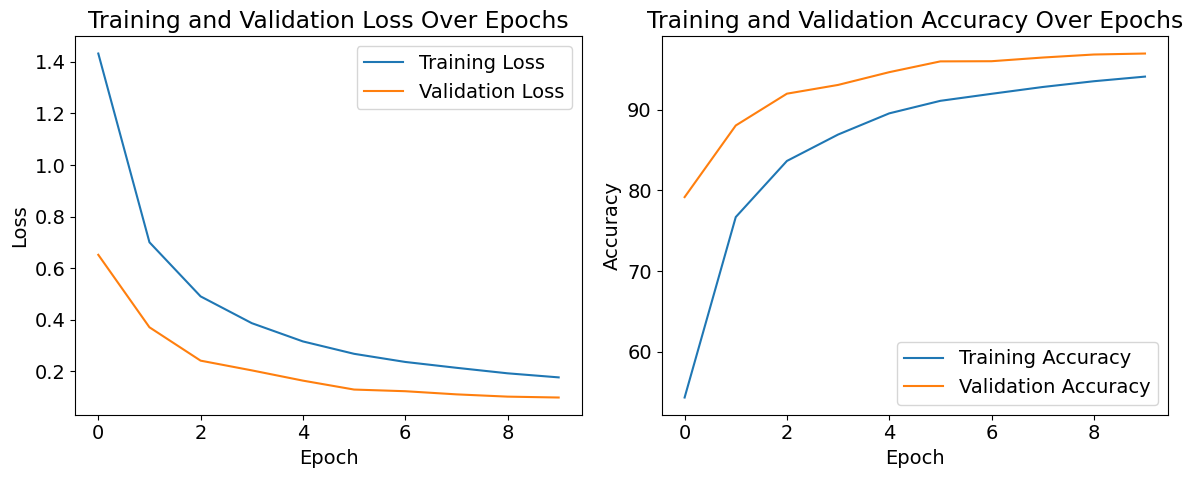

In [43]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


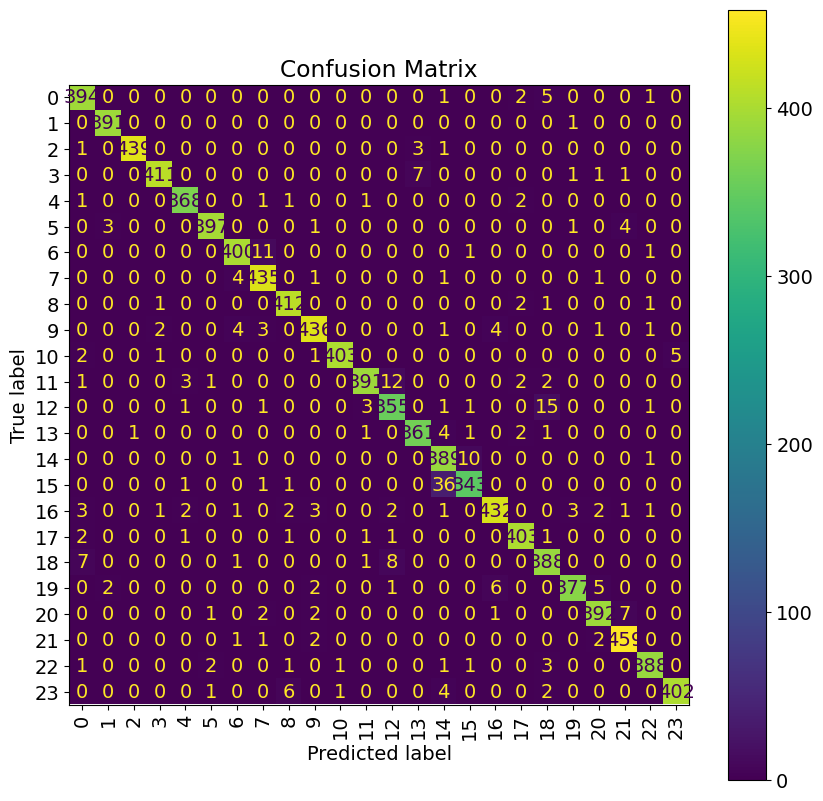

In [44]:
num_classes = 24
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [48]:
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)], output_dict=True)
df_report = pd.DataFrame(report).transpose()

print(df_report)

df_report.to_csv('classification_report.csv', index=True)

              precision    recall  f1-score      support
Class 0        0.956311  0.977667  0.966871   403.000000
Class 1        0.987374  0.997449  0.992386   392.000000
Class 2        0.997727  0.988739  0.993213   444.000000
Class 3        0.987981  0.976247  0.982079   421.000000
Class 4        0.978723  0.983957  0.981333   374.000000
Class 5        0.987562  0.977833  0.982673   406.000000
Class 6        0.970874  0.968523  0.969697   413.000000
Class 7        0.956044  0.984163  0.969900   442.000000
Class 8        0.971698  0.988010  0.979786   417.000000
Class 9        0.973214  0.964602  0.968889   452.000000
Class 10       0.995062  0.978155  0.986536   412.000000
Class 11       0.982412  0.949029  0.965432   412.000000
Class 12       0.936675  0.939153  0.937913   378.000000
Class 13       0.973046  0.973046  0.973046   371.000000
Class 14       0.884091  0.970075  0.925089   401.000000
Class 15       0.960784  0.897906  0.928281   382.000000
Class 16       0.975169  0.9515

In [46]:
# # Test accuracy
# # Test loop
# model.eval()
# running_test_loss = 0.0
# correct_test = 0
# total_test = 0
# all_labels = []
# all_predictions = []
# with torch.no_grad():
#     #print(len(test_loader))
#     for images, labels in test_loader:
#         # move images and labels to device
#         images, labels = images.to(device), labels.to(device)
#         
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         running_test_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total_test += labels.size(0)
#         correct_test += (predicted == labels).sum().item()
#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())
# 
# epoch_test_loss = running_test_loss / len(test_loader)
# test_accuracy = 100 * correct_test / total_test
# 
# print(f"Test Loss: {epoch_test_loss}, Test Accuracy: {test_accuracy}%")

In [47]:
model.eval()
test_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0
all_test_labels = []
all_test_predictions = []
test_progress_bar = tqdm(test_loader, desc='Testing')

with torch.no_grad():
    for data in test_progress_bar:
        grayscale_images, color_images, labels = data

        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        landmarks = process_with_mediapipe(color_images)

        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_predictions += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

        test_progress_bar.set_postfix({
            'test_loss': test_loss / (test_progress_bar.n + 1),
            'test_accuracy': test_correct_predictions / test_total_predictions
        })
epoch_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct_predictions / test_total_predictions
print(f'Test loss: {epoch_test_loss:.3f}, Test accuracy: {test_accuracy:.3f}')

print('Finished Training and Testing')

Testing:   0%|          | 0/309 [00:00<?, ?it/s]/opt/miniconda3/envs/cs221/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Testing: 100%|██████████| 309/309 [08:27<00:00,  1.64s/it, test_loss=0.0967, test_accuracy=0.972]

Test loss: 0.097, Test accuracy: 97.233
Finished Training and Testing


In [50]:
import matplotlib.pyplot as plt

mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence = 0.5)

def process_with_mediapipe_full(color_images):
    processed_images = []
    count_coord = 0
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8) 
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        if results.multi_hand_landmarks:
            count_coord += 1
            for hand_landmarks in results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    color_image_np, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
        color_image_np = color_image_np.astype(np.float32) / 255.0  
        processed_images.append(torch.tensor(color_image_np).permute(2, 0, 1))
    return torch.stack(processed_images), count_coord



# Function to visualize a batch of images
# def visualize_batch(grayscale_images, color_images, processed_color_images):
#     batch_size = grayscale_images.size(0)
# 
#     fig, axes = plt.subplots(batch_size, 3, figsize=(12, batch_size * 4))
#     for i in range(batch_size):
#         # Grayscale image
#         axes[i, 0].imshow(grayscale_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
#         axes[i, 0].set_title('Grayscale Image')
#         axes[i, 0].axis('off')
# 
#         # Original color image
#         axes[i, 1].imshow(color_images[i].permute(1, 2, 0).cpu().numpy())
#         axes[i, 1].set_title('Original Color Image')
#         axes[i, 1].axis('off')
# 
#         # Processed color image with MediaPipe landmarks
#         axes[i, 2].imshow(processed_color_images[i].permute(1, 2, 0).cpu().numpy())
#         axes[i, 2].set_title('Processed Color Image')
#         axes[i, 2].axis('off')
# 
#     plt.tight_layout()
#     plt.show()

# # Fetch a single batch of images from the DataLoader
# data_iter = iter(train_loader)
# grayscale_images, color_images, labels = next(data_iter)
# 
# # Process color images with MediaPipe
# processed_color_images, count_coord = process_with_mediapipe_full(color_images)
# 
# # Visualize the batch
# visualize_batch(grayscale_images, color_images, processed_color_images)
# 
# print(count_coord/len(color_images))
total_images = 0
total_images_with_coordinates = 0

for grayscale_images, color_images, labels in train_loader:
    # Process color images with MediaPipe
    processed_color_images, count_coord = process_with_mediapipe_full(color_images)

    # Accumulate counts
    total_images += len(color_images)
    total_images_with_coordinates += count_coord

    # Visualize the current batch (optional)
    #visualize_batch(grayscale_images, color_images, processed_color_images)

overall_percentage = total_images_with_coordinates / total_images * 100
print(f"Overall percentage of images with coordinates: {overall_percentage:.2f}%")


I0000 00:00:1717598562.640284 1058391 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2
W0000 00:00:1717598562.672822 1517199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717598562.687242 1517199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/cs221/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Overall percentage of images with coordinates: 23.27%
